# Installs

In [ ]:
!pip install bnlp_toolkit

     |████████████████████████████████| 23.9MB 114kB/s 
     |████████████████████████████████| 1.2MB 36.9MB/s 
     |████████████████████████████████| 747kB 34.1MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-2ybdybcw
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-2ybdybcw
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6408 sha256=74ced04c919196457344e68480b3072e0c0ea761f52597f7729e9e88b387925d
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6tkwhkv/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [ ]:
!pip install bnltk

In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 634kB 30.5MB/s 


# Imports

In [ ]:
import pandas as pd
import numpy as np
import random
import re
import os
import gensim
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.feature_extraction.text import CountVectorizer

from bnlp.corpus import stopwords as stopwords_1, punctuations, digits
from bnlp.corpus.util import remove_stopwords

from bengali_stemmer.rafikamal2014 import RafiStemmer
from bnltk.tokenize import Tokenizers

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


punkt not found. downloading...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Pyro specific Imports

import math
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
import pyro.distributions as dist
from tqdm import trange

In [ ]:
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

# Connect Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/THESIS/BprodLDA'

!pip install cache-magic
import cache_magic
!mkdir .cache
!ln -s '/content/drive/My Drive/THESIS/BprodLDA/.cache' /content/.cache

/content/drive/My Drive/THESIS/BprodLDA
  Created wheel for cache-magic: filename=cache_magic-1.0.4-cp37-none-any.whl size=6698 sha256=10a2bee57a365812b3121b835f4b7312cb751fefb93c98e971758907a1b8f76c
  Stored in directory: /root/.cache/pip/wheels/84/3a/44/00b6aea43fe9fcd0c86bbcf33b7e45d167a6b6a1803983325e
Successfully built cache-magic
mkdir: cannot create directory ‘.cache’: File exists


# Get Dataset

In [ ]:
articles = pd.read_csv('/content/drive/MyDrive/THESIS/Final Dataset/all_final_reduced.csv', error_bad_lines=False)
print(articles.isnull().sum())
articles

Full_Text    0
Headline     0
Date         0
Topic        0
Source       0
Year         0
dtype: int64


,Full_Text,Headline,Date,Topic,Source,Year
0,"তিনি বলেছেন, “মানুষের যে ভোটের অধিকার সেটা হচ...",সংবিধানের দোহাই দিয়ে জনগণকে ‘অধিকারহীন’ করে র...,০৬-০১-২০১৮,রাজনীতি,bdnews24,২০১৮
1,শিবচর থানার পরিদর্শক (তদন্ত) শাজাহান মিয়া জান...,মাদারীপুরের শিবপুর উপজেলায় এক গৃহবধূকে ‘মেরে ...,০৯-০৮-২০১৮,বাংলাদেশ,bdnews24,২০১৮
2,আগামী ১৩ ও ১৪ মে কানাডার টরন্টো প্যাভিলিয়নে এ...,কানাডা প্রবাসী বাংলাদেশিদের আয়োজনে তৃতীয়বারের...,০৩-০৪-২০১৭,প্রবাস,bdnews24,২০১৭
3,দুটি যুব বিশ্বকাপে বাংলাদেশ দলের অধিনায়ক ছিলে...,২০১৬ যুব বিশ্বকাপে শেষ কোনো দলকে নেতৃত্ব দিয়ে...,০৫-০১-২০১৯,খেলা,bdnews24,২০১৯
4,উড়োজাহাজটিতে ৪৮ জন যাত্রী এবং পাঁচ ক্রু ছিল। ...,রাশিয়ায় সাইবেরিয়ার একটি বিমানবন্দরে এন্টোনভ এ...,২৭-০৬-২০১৯,আন্তর্জাতিক,bdnews24,২০১৯
...,...,...,...,...,...,...
288255,প্রণোদনা প্যাকেজের সুবিধা দুষ্ট চক্রদের নেওয়ার...,প্রণোদনা প্যাকেজের সুবিধা দুষ্ট চক্রের নেওয়ার ...,১৯-০৪-২০২০,বাণিজ্য,kalerkantha,২০২০
288256,আগামী ১৮ এপ্রিলের জাতীয় সংসদের সপ্তম অধিবেশনে...,আসন্ন সংসদ অধিবেশনে সাংবাদিকদের প্রবেশের অনুমত...,১৪-০৪-২০২০,বাংলাদেশ,jugantor,২০২০
288257,কোভিড-১৯ এ আক্রান্ত হয়ে প্রেসিডেন্ট ডনাল্ড ট্...,পরীক্ষায় হোয়াইট হাউসের চিফ অব স্টাফ মার্ক মেড...,০৭-১১-২০২০,আন্তর্জাতিক,bdnews24,২০২০
288258,পুনর্গঠিত রাঙ্গামাটি পার্বত্য জেলা পরিষদের নতু...,রাঙ্গামাটি জেলা পরিষদের নতুন কমিটির দায়িত্ব গ্রহণ,১৪-১২-২০২০,বাংলাদেশ,jugantor,২০২০


In [ ]:
'''#drop Summary Field
articles.drop('Summary', inplace=True, axis=1)
articles.reset_index(drop=True)
articles'''
articles.dropna(inplace=True)
articles.reset_index(drop=True, inplace=True)
articles.isnull().sum()

Full_Text    0
Headline     0
Date         0
Topic        0
Source       0
Year         0
dtype: int64

In [ ]:
random.seed(42)
bangla_news_list = articles.Full_Text.to_list()
print(bangla_news_list[31])
random.shuffle(bangla_news_list)
print(bangla_news_list[31])

 রেসিপিগুলো দিয়েছেন লিন্ডা ইসলাম । মোরগ-পোলাও উপকরণ: মুরগি ১ কেজির একটা (টুকরা করে ধুয়ে নেওয়া)। বাসমতি চাল আধা কেজি (ধুয়ে রাখা)। দুধ ১ কাপ। আদাবাটা দেড় টেবিল-চামচ। রসুনবাটা ১ টেবিল-চামচ। গরম মসলা ১ টেবিল-চামচ (এলাচ, দারুচিনি, জায়ফল, জয়ত্রী, লং- সব নিয়ে গুঁড়া করে নেবেন)। ঘি ১ কাপ। কাঁচামরিচ-বাটা ১ টেবিল-চমচ। লবণ স্বাদ মতো। পেঁয়াজকুচি আধাকাপ। মিষ্টিদই ৩,৪কাপ। আটার ডো (আটা আধা কেজি নিয়ে ডো তৈরি করুন)। এলাচগুঁড়া আধা চা-চামচ। লেবুর রস ১ টেবিল-চামচ। সাজানোর জন্য: আনার দানা, পুদিনাপাতা, তেজ পাতা ৫,৬টি, গোলাপ-জল ১ টেবিল-চামচ ও বেরেস্তা ১ কাপ। পদ্ধতি: প্রথমে একটি পাত্রে মুরগির মাংসের সঙ্গে আদাবাটা, রসুনবাটা, গরম মসলা, দই, কাঁচামরিচ-বাটা সব একসঙ্গে মাখিয়ে ঢেকে সারারাত ফ্রিজে রেখে দিতে হবে। একটা বড় হাঁড়িতে ৩ কাপ পানি, ১ কাপ দুধ, আধা চা-চামচ আদাবাটা, আস্তএলাচ, দারুচিনি, তেজপাতা, লবণ দিয়ে চুলায় বসান। পানি ফুটে উঠলে ধুয়ে রাখা চাল ঢেলে দিয়ে দিন। চাল যখন ৭০ ভাগের মতো সেদ্ধ হবে তবে সামান্য শক্ত থাকবে তখন নামিয়ে একটা চালনিতে রাখতে হবে যেন পানি ঝরে যায়। তারপর অন্য একটি পাত্রে মানে যে পাত্রে মোরগ-পোলাও কর

# Pre-process

In [ ]:
stopwords_2 = "অবশ্য অনেক অনেকে অনেকেই অন্তত অথবা অথচ অর্থাত অন্য আজ আছে আপনার আপনি আবার আমরা আমাকে আমাদের আমার আমি আরও আর আগে আগেই আই অতএব আগামী অবধি অনুযায়ী আদ্যভাগে এই একই একে একটি এখন এখনও এখানে এখানেই এটি এটা এটাই এতটাই এবং একবার এবার এদের এঁদের এমন এমনকী এল এর এরা এঁরা এস এত এতে এসে একে এক এ ঐ ই ইহা ইত্যাদি উনি উপর উপরে উচিত ও ওই ওর ওরা ওঁর ওঁরা ওকে ওদের ওঁদের ওখানে কত কবে করতে কয়েক কয়েকটি করবে করলেন করার কারও করা করি করিয়ে করার করাই করলে করলেন করিতে করিয়া করেছিলেন করছে করছেন করেছেন করেছে করেন করবেন করায় করে করেই কাছ কাছে কাজে কারণ কিছু কিছুই কিন্তু কিংবা কি কী কেউ কেউই কাউকে কেন কে কোনও কোনো কোন কখনও ক্ষেত্রে খুব গুলি গিয়ে গিয়েছে গেছে গেল গেলে গোটা চলে ছাড়া ছাড়াও ছিলেন ছিল জন্য জানা ঠিক তিনি তিনঐ তিনিও তখন তবে তবু তাঁদের তাঁাহারা তাঁরা তাঁর তাঁকে তাই তেমন তাকে তাহা তাহাতে তাহার তাদের তারপর তারা তারৈ তার তাহলে তিনি তা তাও তাতে তো তত তুমি তোমার তথা থাকে থাকা থাকায় থেকে থেকেও থাকবে থাকেন থাকবেন থেকেই দিকে দিতে দিয়ে দিয়েছে দিয়েছেন দিলেন দু দুটি দুটো দেয় দেওয়া দেওয়ার দেখা দেখে দেখতে দ্বারা ধরে ধরা নয় নানা না নাকি নাগাদ নিতে নিজে নিজেই নিজের নিজেদের নিয়ে নেওয়া নেওয়ার নেই নাই পক্ষে পর্যন্ত পাওয়া পারেন পারি পারে পরে পরেই পরেও পর পেয়ে প্রতি প্রভৃতি প্রায় ফের ফলে ফিরে ব্যবহার বলতে বললেন বলেছেন বলল বলা বলেন বলে বহু বসে বার বা বিনা বরং বদলে বাদে বার বিশেষ বিভিন্ন বিষয়টি ব্যবহার ব্যাপারে ভাবে ভাবেই মধ্যে মধ্যেই মধ্যেও মধ্যভাগে মাধ্যমে মাত্র মতো মতোই মোটেই যখন যদি যদিও যাবে যায় যাকে যাওয়া যাওয়ার যত যতটা যা যার যারা যাঁর যাঁরা যাদের যান যাচ্ছে যেতে যাতে যেন যেমন যেখানে যিনি যে রেখে রাখা রয়েছে রকম শুধু সঙ্গে সঙ্গেও সমস্ত সব সবার সহ সুতরাং সহিত সেই সেটা সেটি সেটাই সেটাও সম্প্রতি সেখান সেখানে সে স্পষ্ট স্বয়ং হইতে হইবে হৈলে হইয়া হচ্ছে হত হতে হতেই হবে হবেন হয়েছিল হয়েছে হয়েছেন হয়ে হয়নি হয় হয়েই হয়তো হল হলে হলেই হলেও হলো হিসাবে হওয়া হওয়ার হওয়ায় হন হোক জন জনকে জনের জানতে জানায় জানিয়ে জানানো জানিয়েছে জন্য জন্যওজে জে বেশ দেন তুলে ছিলেন চান চায় চেয়ে মোট যথেষ্ট টি অতএব অথচ অথবা অনুযায়ী অনেক অনেকে অনেকেই অন্তত অন্য অবধি অবশ্য অর্থাত আই আগামী আগে আগেই আছে আজ আদ্যভাগে আপনার আপনি আবার আমরা আমাকে আমাদের আমার আমি আর আরও ই ইত্যাদি ইহা উচিত উত্তর উনি উপর উপরে এ এঁদের এঁরা এই একই একটি একবার একে এক্ এখন এখনও এখানে এখানেই এটা এটাই এটি এত এতটাই এতে এদের এব এবং এবার এমন এমনকী এমনি এর এরা এল এস এসে ঐ ও ওঁদের ওঁর ওঁরা ওই ওকে ওখানে ওদের ওর ওরা কখনও কত কবে কমনে কয়েক কয়েকটি করছে করছেন করতে করবে করবেন করলে করলেন করা করাই করায় করার করি করিতে করিয়া করিয়ে থাকবেন থাকা থাকায় থাকে থাকেন থেকে থেকেই থেকেও দিকে দিতে দিন দিয়ে দিয়েছে দিয়েছেন দিলেন দু দুই দুটি দুটো দেওয়া দেওয়ার দেওয়া দেখতে দেখা দেখে দেন দেয় দ্বারা ধরা ধরে ধামার নতুন নয় না নাই নাকি নাগাদ নানা নিজে নিজেই নিজেদের নিজের নিতে নিয়ে নিয়ে নেই নেওয়া নেওয়ার নেওয়া নয় পক্ষে পর পরে পরেই পরেও পর্যন্ত পাওয়া পাচ পারি পারে পারেন পি পেয়ে পেয়্র্ প্রতি প্রথম প্রভৃতি প্রযন্ত প্রাথমিক প্রায় প্রায় ফলে ফিরে ফের বক্তব্য বদলে বন বরং বলতে বলল বললেন বলা বলে বলেছেন বলেন বসে হু বা বাদে বার বি বিনা বিভিন্ন বিশেষ বিষয়টি  বেশ বেশি ব্যবহার ব্যাপারে ভাবে ভাবেই মতো মতোই মধ্যভাগে মধ্যে মধ্যেই মধ্যেও মনে মাত্র মাধ্যমে মোট মোটেই যখন যত যতটা যথেষ্ট যদি যদিও যা যাঁর যাঁরা যাওয়া যাওয়ার যাওয়া যাকে যাচ্ছে যাতে যাদের যান যাবে যায় যার যারা যিনি যে যেখানে যেতে যেন যেমন র রকম রয়েছে রাখা রেখে লক্ষ শুধু শুরু সঙ্গে সঙ্গেও সব সবার সমস্ত সম্প্রতি সহ সহিত সাধারণ সামনে সি সুতরাং সে সেই নয় না হয় হয়ে হয়েছে হয়ত হয়েছিলেন । , - ; ঃ মিথ্যা শুরু"

In [ ]:
len(stopwords_2.split())

639

In [ ]:
stopwords = []

for word in stopwords_1:
  if word not in stopwords:
    stopwords.append(word)

for word in stopwords_2.split():
  if word not in stopwords:
    stopwords.append(word)

len(stopwords)

In [ ]:
#bn_stopwords = []
with open('/content/drive/MyDrive/THESIS/bn_stopwords.txt', 'r') as fp:
    stopwords = [word.split()[0] for word in fp.readlines()]
len(stopwords)

446

In [ ]:
def preprocess_BN(text, stop_words=None):
  #text = text.split()
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  text = re.sub(r'\<a href', ' ', text)
  text = re.sub(r'&amp;', '', text) 
  text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
  text = re.sub(r'<br />', ' ', text)
  text = re.sub(r'\'', ' ', text)
  text = re.sub(r'।', ' ', text)
  text = re.sub(r'[‘’]', ' ', text)
  text = re.sub(r'[০১২৩৪৫৬৭৮৯123456789]', ' ', text)
  text = re.sub(r'[a-zA-Z]', ' ', text)
  #text = " ".join(text)
  
  #print("In PP (before stopwords): {}".format(text))
  '''text = text.split(' ')
  text = [word for word in text if word not in stopwords]'''
  
  tokenizer = Tokenizers()
  stemmer = RafiStemmer()

  #stop_words = load_stop_word()
  

  doc_token = []

  if isinstance(text, str):
    for token in tokenizer.bn_word_tokenizer(text):
      if token not in stop_words and len(token) >= 3:
        stemmed_token = stemmer.stem_word(token)
        if len(stemmed_token) >= 2 and stemmed_token not in stop_words:
          doc_token.append(stemmed_token)


  #text = remove_stopwords(text, stopwords=stopwords)

  '''if isinstance(text, str):
    text = text.split()
  text = stemming_docs(text)'''
  #print(text)
  return " ".join(doc_token)

In [ ]:
def preprocess_BN_wo_stem(text, stop_words=None):
  #text = text.split()
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  text = re.sub(r'\<a href', ' ', text)
  text = re.sub(r'&amp;', '', text) 
  text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
  text = re.sub(r'<br />', ' ', text)
  text = re.sub(r'\'', ' ', text)
  text = re.sub(r'।', ' ', text)
  text = re.sub(r'[‘’]', ' ', text)
  text = re.sub(r'[০১২৩৪৫৬৭৮৯123456789]', ' ', text)
  text = re.sub(r'[a-zA-Z]', ' ', text)
  #text = " ".join(text)
  
  #print("In PP (before stopwords): {}".format(text))
  '''text = text.split(' ')
  text = [word for word in text if word not in stopwords]'''
  
  tokenizer = Tokenizers()
  stemmer = RafiStemmer()

  #stop_words = load_stop_word()
  

  doc_token = []

  if isinstance(text, str):
    for token in tokenizer.bn_word_tokenizer(text):
      if token not in stop_words and len(token) >= 3:
        doc_token.append(token)


  #text = remove_stopwords(text, stopwords=stopwords)

  '''if isinstance(text, str):
    text = text.split()
  text = stemming_docs(text)'''
  #print(text)
  return " ".join(doc_token)

In [ ]:
%cache bangla_news_list = bangla_news_list

Loading cached value for variable 'bangla_news_list'. Time since caching: 18:48:19.434623


In [ ]:
# remove symbols, punctuations, and stopwords

pp_bangla_news_list = []
for bangla_news in bangla_news_list:
  #print("Type: {}".format(type(str(bangla_news))))
  #print("Before PP: {}".format(bangla_news))
  pp_bangla_news_list.append(preprocess_BN(bangla_news, stop_words=stopwords))
  #print("After PP: {}\n\n".format(pp_bangla_news_list[-1]))

In [ ]:
%cache pp_bangla_news_list = pp_bangla_news_list

Loading cached value for variable 'pp_bangla_news_list'. Time since caching: 4 days, 0:35:08.057167


In [ ]:
# remove symbols, punctuations, and stopwords

reduced_pp_bangla_news_list = []
for bangla_news in bangla_news_list:
  #print("Type: {}".format(type(str(bangla_news))))
  #print("Before PP: {}".format(bangla_news))
  reduced_pp_bangla_news_list.append(preprocess_BN(bangla_news, stop_words=stopwords))
  #print("After PP: {}\n\n".format(pp_bangla_news_list[-1]))

In [ ]:
%cache reduced_pp_bangla_news_list = reduced_pp_bangla_news_list

Loading cached value for variable 'reduced_pp_bangla_news_list'. Time since caching: 3 days, 1:42:56.041025


In [ ]:
pp_bangla_news_list_wo_stem = []
for bangla_news in bangla_news_list:
  #print("Type: {}".format(type(str(bangla_news))))
  #print("Before PP: {}".format(bangla_news))
  pp_bangla_news_list_wo_stem.append(preprocess_BN_wo_stem(bangla_news, stop_words=stopwords))
  #print("After PP: {}\n\n".format(pp_bangla_news_list[-1]))

In [ ]:
%cache pp_bangla_news_list_wo_stem = pp_bangla_news_list_wo_stem

Loading cached value for variable 'pp_bangla_news_list_wo_stem'. Time since caching: 0:04:20.497818


In [ ]:
for i in range(500,505):
  print("Before PP: {}".format(bangla_news_list[i]))
  print("After PP: {}\n\n".format(pp_bangla_news_list[i]))

Before PP: কানাডার ম্যানিটোবা বিশ্ববিদ্যালয়ে পোস্ট ডক্টরাল ফেলো হিসেবে মেডিকেল মাইক্রোবায়োলজি বিভাগের খ্যাতনামা অধ্যাপক কেভিন কোমবসের সঙ্গে ইনফ্লুয়েঞ্জা (ফ্লু) ভাইরাসের টিকা বা ওষুধ আবিষ্কারের একটি প্রকল্পে কাজ করার সুযোগ হয়েছিল। তাই পেশাগত দায়িত্ববোধ ও সংশ্লিষ্ট বিষয়ে গবেষণার অভিজ্ঞতা থেকে এ বিষয়ে লিখতে বসা। সাম্প্রতিক সময়ে দেশে, বিশেষ করে ঢাকায় চিকুনগুনিয়ার ব্যাপক প্রকোপ দেখা দিয়েছে। পত্রপত্রিকার তথ্যমতে, আক্রান্ত ব্যক্তির সংখ্যা ঢাকায় প্রতি ১১ জনে ১ জন।  চিকুনগুনিয়া ভাইরাস দ্বারা সৃষ্ট একটি রোগ। এডিস মশা দ্বারা চিকুনগুনিয়া ভাইরাস শরীরে প্রবেশের দুই থেকে চার দিনের মধ্যে আকস্মিক জ্বর শুরু হয়। এর সঙ্গে অস্থিসন্ধিতে ব্যথা করতে থাকে, যা কয়েক সপ্তাহ, মাস বা বছর পর্যন্ত স্থায়ী হতে পারে। এই রোগে মৃত্যুঝুঁকি প্রতি ১০ হাজারে ১ জন বা এর চেয়েও কম। তবে বয়স্ক ও শিশুদের ক্ষেত্রে এই রোগের জটিলতা তুলনামূলক বেশি।  বিশেষজ্ঞদের মতে, চিকুনগুনিয়ার কোনো চিকিৎসা নেই। সাধারণত দুই থেকে তিন দিনের (কোনো কোনো ক্ষেত্রে সর্বোচ্চ ১০ দিন) মধ্যেই আপনাআপনি এই রোগ সেরে যায়। তবে পাঁচ থেকে সাত দিন পর্যন্ত এই রোগের জীবাণ

In [ ]:
import regex 

def custom_analyzer(text):
    words = regex.findall(r'\w{2,}', text) # extract words of at least 2 letters
    for w in words:
        yield w

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
# Vectorize the dataset FOR BANGLA
vectorizer_BN = CountVectorizer(analyzer=custom_analyzer,
                                max_df=0.7, min_df=0.002) #'''max_df=0.5, min_df=2'''
docs_BN = torch.from_numpy(vectorizer_BN.fit_transform(pp_bangla_news_list[:95000]).toarray()) # .astype('int16')
#print("Changes Accepted.")
vocab_BN = pd.DataFrame(columns=['word', 'index'])
vocab_BN['word'] = vectorizer_BN.get_feature_names()
vocab_BN['index'] = vocab_BN.index

In [ ]:
# Vectorize the dataset FOR BANGLA
vectorizer_BN = CountVectorizer(analyzer=custom_analyzer,
                                max_df=0.7, min_df=0.003) #'''max_df=0.5, min_df=2'''
docs_BN = torch.from_numpy(vectorizer_BN.fit_transform(reduced_pp_bangla_news_list[:90000]).toarray()) # .astype('int16')
#print("Changes Accepted.")
vocab_BN = pd.DataFrame(columns=['word', 'index'])
vocab_BN['word'] = vectorizer_BN.get_feature_names()
vocab_BN['index'] = vocab_BN.index

In [ ]:
vocab_BN

,word,index
0,অংক,0
1,অংশ,1
2,অংশগ্রহণ,2
3,অংশগ্রহণকারী,3
4,অংশীদ,4
...,...,...
5332,হ্যান্ড,5332
5333,হ্রাস,5333
5334,হয়ত,5334
5335,হয়রানি,5335


In [ ]:
print('Dictionary size: %d' % len(vocab_BN))
print('Corpus size: {}'.format(docs_BN.shape))

Dictionary size: 7013
Corpus size: torch.Size([100000, 7013])


# Build Model

In [ ]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale

In [ ]:
class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)

In [ ]:
class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample("logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

In [ ]:
print(docs_BN.dtype)

torch.float32


In [ ]:
# setting global variables for Bangla
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 20 if not smoke_test else 3
docs_BN = docs_BN.float().to(device)
batch_size = 64
learning_rate = 1e-3
num_epochs = 50 if not smoke_test else 1

In [ ]:
# training
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs_BN.shape[1],
    num_topics=num_topics,
    hidden=256 if not smoke_test else 10,
    dropout=0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs_BN.shape[0] / batch_size)) if not smoke_test else 1

bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs_BN[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

100%|██████████| 50/50 [09:24<00:00, 11.29s/it, epoch_loss=7.85e+05]


In [ ]:
for param_tensor in prodLDA.state_dict():
    print(param_tensor, "\t", prodLDA.state_dict()[param_tensor].size())

encoder.fc1.weight 	 torch.Size([100, 4404])
encoder.fc1.bias 	 torch.Size([100])
encoder.fc2.weight 	 torch.Size([100, 100])
encoder.fc2.bias 	 torch.Size([100])
encoder.fcmu.weight 	 torch.Size([15, 100])
encoder.fcmu.bias 	 torch.Size([15])
encoder.fclv.weight 	 torch.Size([15, 100])
encoder.fclv.bias 	 torch.Size([15])
encoder.bnmu.running_mean 	 torch.Size([15])
encoder.bnmu.running_var 	 torch.Size([15])
encoder.bnmu.num_batches_tracked 	 torch.Size([])
encoder.bnlv.running_mean 	 torch.Size([15])
encoder.bnlv.running_var 	 torch.Size([15])
encoder.bnlv.num_batches_tracked 	 torch.Size([])
decoder.beta.weight 	 torch.Size([4404, 15])
decoder.bn.running_mean 	 torch.Size([4404])
decoder.bn.running_var 	 torch.Size([4404])
decoder.bn.num_batches_tracked 	 torch.Size([])


In [ ]:
PATH = os.path.join('/content/drive/My Drive/THESIS/BprodLDA/Model/', 'BprodLDA_20_reduced.pth')
torch.save({
            'epoch': epoch,
            'model_state_dict': prodLDA.state_dict(),
            'loss': loss
            }, PATH)

# Inspecting

In [ ]:
PATH = os.path.join('/content/drive/My Drive/THESIS/BprodLDA/Model/', 'BprodLDA_bigram.pth')

prodLDA = ProdLDA(
    vocab_size=docs_BN.shape[1],
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2
)
optimizer = pyro.optim.Adam({"lr": learning_rate})

checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
prodLDA.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

prodLDA.eval()

ProdLDA(
  (encoder): Encoder(
    (drop): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=5324, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fcmu): Linear(in_features=100, out_features=20, bias=True)
    (fclv): Linear(in_features=100, out_features=20, bias=True)
    (bnmu): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (bnlv): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (decoder): Decoder(
    (beta): Linear(in_features=20, out_features=5324, bias=False)
    (bn): BatchNorm1d(5324, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
)

In [ ]:
!wget https://www.omicronlab.com/download/fonts/kalpurush.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf

--2021-07-03 22:07:13--  https://www.omicronlab.com/download/fonts/kalpurush.ttf
Resolving www.omicronlab.com (www.omicronlab.com)... 172.104.46.32
Connecting to www.omicronlab.com (www.omicronlab.com)|172.104.46.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314592 (307K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/kalpurush.ttf.1’

kalpurush.ttf.1     100%[===================>] 307.22K   608KB/s    in 0.5s    

2021-07-03 22:07:15 (608 KB/s) - ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/kalpurush.ttf.1’ saved [314592/314592]



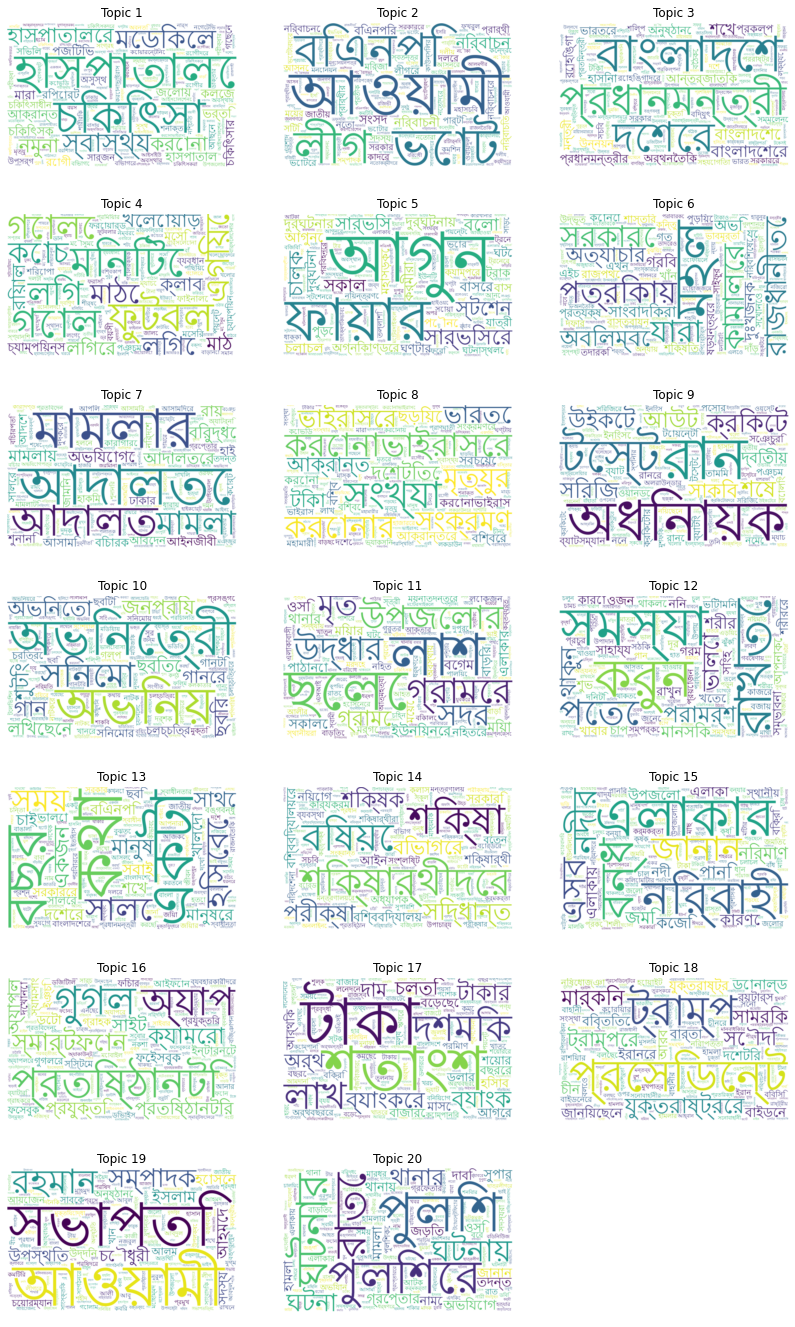

In [ ]:
#Bangla cloud plotting
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices.numpy(), columns=['index'])
    words = pd.merge(df, vocab_BN[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_ * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(font_path='/content/drive/My Drive/Fonts/Lohit_Bengali_400.ttf', background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

if not smoke_test:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    beta = prodLDA.beta()
    fig, axs = plt.subplots(7, 3, figsize=(14, 24))
    for n in range(beta.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud(beta[n], axs[i, j], vocab_BN, n)
    axs[-1, -1].axis('off');

    plt.show()

In [ ]:
beta = prodLDA.beta()

In [ ]:
topics_prod = []

for b in beta:
  sorted_, indices = torch.sort(b, descending=True)
  df = pd.DataFrame(indices.numpy(), columns=['index'])
  words = pd.merge(df, vocab_BN[['index', 'word']],
                   how='left', on='index')['word'].values.tolist()
  sizes = (sorted_ * 1000).int().numpy().tolist()
  #print(len(words))
  topics_prod.append(words[:10])

In [ ]:
topics_prod_2 = []

for b in beta:
  sorted_, indices = torch.sort(b, descending=True)
  df = pd.DataFrame(indices.numpy(), columns=['index'])
  words = pd.merge(df, vocab_BN[['index', 'word']],
                   how='left', on='index')['word'].values.tolist()
  sizes = (sorted_ * 1000).int().numpy().tolist()
  #print(len(words))
  topics_prod_2.append(words[:10])

In [ ]:
for topic in topics_prod:
    print(topic)

['গোল', 'মিনিট', 'ফুটবল', 'লিগ', 'মাঠ', 'কোচ', 'খেলোয়াড়', 'মৌসুম', 'রিয়াল', 'বক্স']
['অ্যাপল', 'স্মার্টফোন', 'গুগল', 'অ্যাপ', 'প্রযুক্তি', 'ব্যবহারকারী', 'আইফোন', 'ফোন', 'ডিভাইস', 'সাইট']
['ভালো', 'সম', 'পাব', 'সাথ', 'আপনা', 'থাক', 'নারী', 'জীবন', 'শুভ', 'সামাজিক']
['যুক্তরাষ্ট্র', 'প্রেসিডেন্ট', 'ট্রাম্প', 'মার্কিন', 'জানিয়', 'সংস্থা', 'বিবৃতি', 'সামরিক', 'ইরান', 'সেনা']
['খাব', 'গরম', 'চুল', 'দুধ', 'উপাদান', 'খাবার', 'রাখ', 'পরিষ্ক', 'অল্প', 'শরীর']
['আক্রান্ত', 'স্বাস্থ্য', 'করোনা', 'সংখ্যা', 'করোনাভাইরাস', 'ভাইরাস', 'হাসপাতাল', 'রোগীর', 'করোন', 'সংক্রমণ']
['শিক্ষার্থী', 'শিক্ষা', 'আইন', 'বিভাগ', 'কমি', 'শিক্ষক', 'বিশ্ববিদ্যালয়', 'পরীক্ষা', 'সরকারি', 'কর্মকর্তা']
['পুলিশ', 'ঘটনা', 'থান', 'থানা', 'বাড়ি', 'ঘটন', 'জানান', 'গ্রেপ্ত', 'নাম', 'ওসি']
['টাকা', 'শতাংশ', 'ব্যাংক', 'লাখ', 'দশমিক', 'কোম্পানি', 'বেড়', 'কম', 'দাম', 'মাস']
['আগুন', 'ফায়', 'সার্ভিস', 'অগ্নিকাণ্ড', 'বিজি', 'এলাকায়', 'সার্ভ', 'পুড়', 'জব্দ', 'স্টেশন']
['পড়', 'এলাকা', 'বন্ধ', 'জানান', 'কিলোমিট', 'উপজেলা', 'রাস্তা', 'ব

In [ ]:
for topic in topics_prod_2:
    print(topic)

['গোল', 'মিনিট', 'ফুটবল', 'লিগ', 'মাঠ', 'কোচ', 'খেলোয়াড়', 'মৌসুম', 'রিয়াল', 'বক্স']
['অ্যাপল', 'স্মার্টফোন', 'গুগল', 'অ্যাপ', 'প্রযুক্তি', 'ব্যবহারকারী', 'আইফোন', 'ফোন', 'ডিভাইস', 'সাইট']
['ভালো', 'সম', 'পাব', 'সাথ', 'আপনা', 'থাক', 'নারী', 'জীবন', 'শুভ', 'সামাজিক']
['যুক্তরাষ্ট্র', 'প্রেসিডেন্ট', 'ট্রাম্প', 'মার্কিন', 'জানিয়', 'সংস্থা', 'বিবৃতি', 'সামরিক', 'ইরান', 'সেনা']
['খাব', 'গরম', 'চুল', 'দুধ', 'উপাদান', 'খাবার', 'রাখ', 'পরিষ্ক', 'অল্প', 'শরীর']
['আক্রান্ত', 'স্বাস্থ্য', 'করোনা', 'সংখ্যা', 'করোনাভাইরাস', 'ভাইরাস', 'হাসপাতাল', 'রোগীর', 'করোন', 'সংক্রমণ']
['শিক্ষার্থী', 'শিক্ষা', 'আইন', 'বিভাগ', 'কমি', 'শিক্ষক', 'বিশ্ববিদ্যালয়', 'পরীক্ষা', 'সরকারি', 'কর্মকর্তা']
['পুলিশ', 'ঘটনা', 'থান', 'থানা', 'বাড়ি', 'ঘটন', 'জানান', 'গ্রেপ্ত', 'নাম', 'ওসি']
['টাকা', 'শতাংশ', 'ব্যাংক', 'লাখ', 'দশমিক', 'কোম্পানি', 'বেড়', 'কম', 'দাম', 'মাস']
['আগুন', 'ফায়', 'সার্ভিস', 'অগ্নিকাণ্ড', 'বিজি', 'এলাকায়', 'সার্ভ', 'পুড়', 'জব্দ', 'স্টেশন']
['পড়', 'এলাকা', 'বন্ধ', 'জানান', 'কিলোমিট', 'উপজেলা', 'রাস্তা', 'ব

In [ ]:
tokenized_corpus = []
for doc in reduced_pp_bangla_news_list[100000:150000]:
  tokenized_corpus.append(list(custom_analyzer(doc)))

In [ ]:
len(tokenized_corpus[2])

456

In [ ]:
from gensim.corpora import Dictionary
#corpus_ = docs_BN.detach().cpu().numpy() # .cpu().numpy().arra
#corpus_
dct = Dictionary(tokenized_corpus)

In [ ]:
len(dict(dct))

287437

In [ ]:
#from gensim.test.utils import common_corpus, common_dictionary

from gensim.models.coherencemodel import CoherenceModel

'''topics = [

    ['human', 'computer', 'system', 'interface'],

    ['graph', 'minors', 'trees', 'eps']

]'''

cm = CoherenceModel(topics=topics_prod_2, texts=tokenized_corpus, dictionary=dct, coherence='c_v')

coherence = cm.get_coherence()
coherence

0.7111443181413973

In [ ]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=prodLDA, corpus=pp_bangla_news_list[:150000],
                    dictionary=dct, coherence='c_v',
                    texts=[[w for w in d if w in dct.token2id] for d in docs_BN])
cm.get_coherence()

# Best n topics

In [ ]:
from gensim.corpora import Dictionary

tokenized_corpus = []
for doc in pp_bangla_news_list[:75000]:
    tokenized_corpus.append(list(custom_analyzer(doc)))

    
#corpus_ = docs_BN.detach().cpu().numpy() # .cpu().numpy().arra
#corpus_
dct = Dictionary(tokenized_corpus)

In [ ]:
from gensim.models import CoherenceModel

topic_coherence = []

topic_numbers = [10, 15, 20, 25, 30, 35, 40, 45, 50]

for num_topics in topic_numbers:
    # training
    print("=" * 15, num_topics, " Topic","=" * 15)
    pyro.clear_param_store()

    prodLDA = ProdLDA(
        vocab_size=docs_BN.shape[1],
        num_topics=num_topics,
        hidden=100 if not smoke_test else 10,
        dropout=0.2
    )
    prodLDA.to(device)

    optimizer = pyro.optim.Adam({"lr": learning_rate})
    svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
    num_batches = int(math.ceil(docs_BN.shape[0] / batch_size)) if not smoke_test else 1

    bar = trange(num_epochs)
    for epoch in bar:
        running_loss = 0.0
        for i in range(num_batches):
            batch_docs = docs_BN[i * batch_size:(i + 1) * batch_size, :]
            loss = svi.step(batch_docs)
            running_loss += loss / batch_docs.size(0)

        bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

    
    
    
    beta = prodLDA.beta()
    topics_prod = []

    for b in beta:
        sorted_, indices = torch.sort(b, descending=True)
        df = pd.DataFrame(indices.numpy(), columns=['index'])
        words = pd.merge(df, vocab_BN[['index', 'word']],
                         how='left', on='index')['word'].values.tolist()
        sizes = (sorted_ * 1000).int().numpy().tolist()
        #print(len(words))
        topics_prod.append(words)


    cm = CoherenceModel(topics=topics_prod, texts=tokenized_corpus, dictionary=dct, coherence='c_v')

    coherence = cm.get_coherence()

    topic_coherence.append((num_topics, coherence))
    print(topic_coherence)
    %cache -r topic_coherence = topic_coherence


  0%|          | 0/10 [00:00<?, ?it/s]

=============== 10  Topic ===============



100%|██████████| 10/10 [01:26<00:00,  8.66s/it, epoch_loss=7.56e+05]

  0%|          | 0/10 [00:00<?, ?it/s]

[(10, 0.6395930137288247)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'
=============== 15  Topic ===============



100%|██████████| 10/10 [01:27<00:00,  8.77s/it, epoch_loss=7.44e+05]

  0%|          | 0/10 [00:00<?, ?it/s]

[(10, 0.6395930137288247), (15, 0.6396251551247423)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'
=============== 20  Topic ===============



100%|██████████| 10/10 [01:27<00:00,  8.78s/it, epoch_loss=7.36e+05]

  0%|          | 0/10 [00:00<?, ?it/s]

[(10, 0.6395930137288247), (15, 0.6396251551247423), (20, 0.7423285873006598)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'
=============== 25  Topic ===============



100%|██████████| 10/10 [01:28<00:00,  8.82s/it, epoch_loss=7.32e+05]

  0%|          | 0/10 [00:00<?, ?it/s]

[(10, 0.6395930137288247), (15, 0.6396251551247423), (20, 0.7423285873006598), (25, 0.700404933541526)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'
=============== 30  Topic ===============



100%|██████████| 10/10 [01:27<00:00,  8.77s/it, epoch_loss=7.30e+05]

  0%|          | 0/10 [00:00<?, ?it/s]

[(10, 0.6395930137288247), (15, 0.6396251551247423), (20, 0.7423285873006598), (25, 0.700404933541526), (30, 0.7015830927824654)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'
=============== 35  Topic ===============



100%|██████████| 10/10 [01:27<00:00,  8.73s/it, epoch_loss=7.29e+05]

  0%|          | 0/10 [00:00<?, ?it/s]

[(10, 0.6395930137288247), (15, 0.6396251551247423), (20, 0.7423285873006598), (25, 0.700404933541526), (30, 0.7015830927824654), (35, 0.688359922117171)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'
=============== 40  Topic ===============



100%|██████████| 10/10 [01:27<00:00,  8.79s/it, epoch_loss=7.28e+05]

  0%|          | 0/10 [00:00<?, ?it/s]

[(10, 0.6395930137288247), (15, 0.6396251551247423), (20, 0.7423285873006598), (25, 0.700404933541526), (30, 0.7015830927824654), (35, 0.688359922117171), (40, 0.706691329756517)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'
=============== 45  Topic ===============



100%|██████████| 10/10 [01:27<00:00,  8.71s/it, epoch_loss=7.27e+05]

  0%|          | 0/10 [00:00<?, ?it/s]

[(10, 0.6395930137288247), (15, 0.6396251551247423), (20, 0.7423285873006598), (25, 0.700404933541526), (30, 0.7015830927824654), (35, 0.688359922117171), (40, 0.706691329756517), (45, 0.7131050418659025)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'
=============== 50  Topic ===============



100%|██████████| 10/10 [01:27<00:00,  8.74s/it, epoch_loss=7.28e+05]


[(10, 0.6395930137288247), (15, 0.6396251551247423), (20, 0.7423285873006598), (25, 0.700404933541526), (30, 0.7015830927824654), (35, 0.688359922117171), (40, 0.706691329756517), (45, 0.7131050418659025), (50, 0.7032120340267976)]
Resetting cached values for topic_coherence
Creating new value for variable 'topic_coherence'


In [ ]:
print("=" * 15, 50, " Topic","=" * 15)

=============== 50  Topic ===============


In [ ]:
%cache topic_coherence = topic_coherence

Loading cached value for variable 'topic_coherence'. Time since caching: 40 days, 12:25:08.315122


In [ ]:
topic_coherence

[(10, 0.6395930137288247),
 (15, 0.6396251551247423),
 (20, 0.7423285873006598),
 (25, 0.700404933541526),
 (30, 0.7015830927824654),
 (35, 0.688359922117171),
 (40, 0.706691329756517),
 (45, 0.7131050418659025),
 (50, 0.7032120340267976)]

In [ ]:
import matplotlib.pyplot as plt

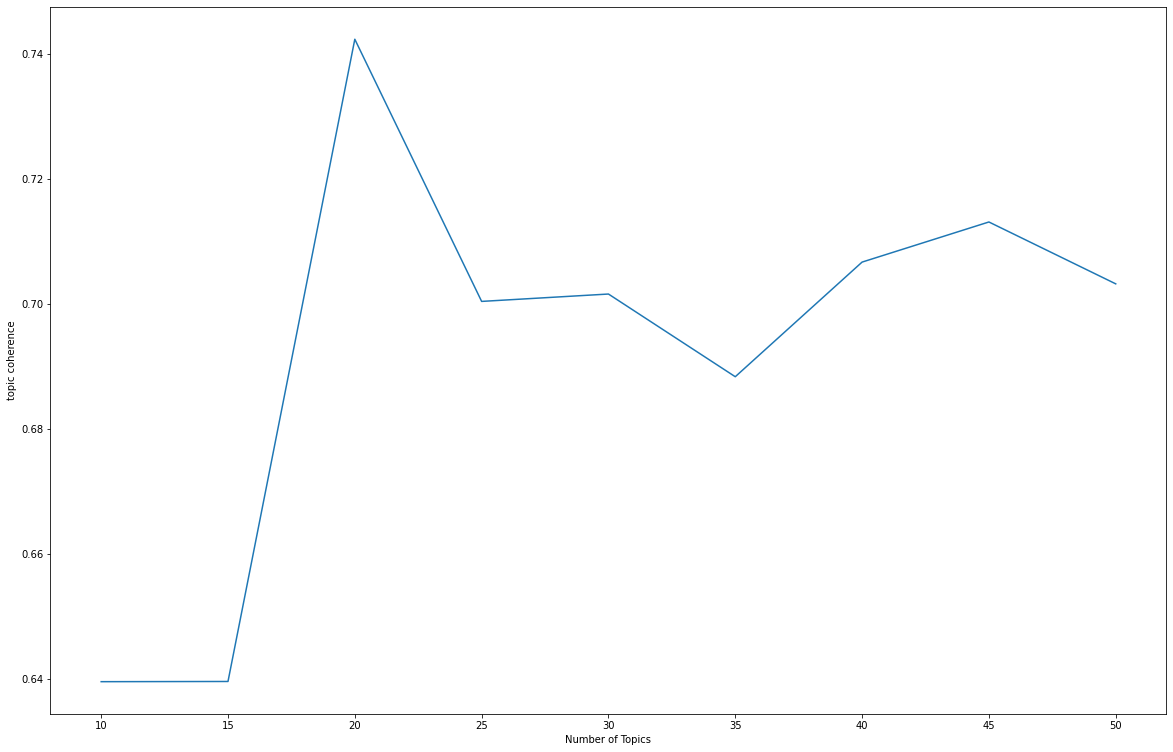

In [ ]:
x = []
y = []

for topic_n, coherence_score in topic_coherence:
    x.append(topic_n)
    y.append(coherence_score)

plt.rcParams["figure.figsize"] = (20,13)
plt.plot(x, y)
plt.xlabel('Number of Topics')
plt.ylabel('topic coherence')
plt.show()